In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
import sys
import numpy as np
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

from importlib import reload

import src.cathay_db as db
import src.utils as ut
import src.financial_statement as fs

reload(ut)
reload(fs)
import matplotlib.pyplot as plt
import datetime
import os
import xgboost as xgb
sys.path.append("./src")

from toolbox import print_progress_bar

# set max display rows
pd.set_option("display.max_rows", 200)

# set max display columns
pd.set_option("display.max_columns", 100)

# Set the float format to display without scientific notation
pd.options.display.float_format = '{:.4f}'.format

import matplotlib

# Set global font to 'Microsoft JhengHei'
matplotlib.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

# import quantstats as qs
# reload(qs)
import matplotlib.ticker as mtick

# Set Model

In [2]:
def create_table(df, cell_heights):
    fig, ax = plt.subplots()
    formatted_data = df.round(2).values.tolist()
    labels = df.columns.tolist()
    
    table = ax.table(cellText=formatted_data, colLabels=labels, colWidths=[.5]*len(labels), loc='center')

    cell_dict = table.get_celld()
    for i, label in enumerate(labels):
        cell_dict[(0,i)].set_height(cell_heights[0])
        for j in range(1, len(formatted_data)+1):
            cell_dict[(j,i)].set_height(cell_heights[1])

    table.set_fontsize(25)
    ax.axis('off')

    return fig, ax

In [3]:
# select model 
model_folder_name = '20230724_091431'
# model_folder_name = '20230719_083148'
# # model_folder_name = '20230712_173216'
# model_folder_name = '20230711_171428'
# model_folder_name = '20230711_110457'
# model_folder_name = '20230707_140403'
# model_folder_name = '20230706_141045'

# load setting from data/model/model_folder_name/setting.json
setting = ut.load_json(f'./data/model/{model_folder_name}/setting.json')

print(setting.keys())
print(setting['factor_columns'])

dict_keys(['start_index', 'rebalance_date_lst', 'factor_columns', 'target_cols', 'model_save_path', 'param_search', 'fit_params'])
['asset_qoq', 'asset_yoy', 'ni_qoq', 'ni_yoy', 'roe', 'roe_yoy', 'roe_4q_sum', 'roe_4q_sum_yoy', 'tobins_q', 'ocf / asset', '20_d_return', '40_d_return', '60_d_return', 'dividend_1Y_sum_yield', 'dividend_2Y_sum_yield', 'dividend_3Y_sum_yield', 'last_dividend_yield']


In [4]:
df_adjusted_price = pd.read_feather('data/df_adjusted_price.feather')
df_adjusted_price.drop_duplicates(inplace=True)
df_adjusted_price.reset_index(drop=True, inplace=True)
df_adjusted_price_pivot = df_adjusted_price.pivot(index='年月日',columns='股票代號',values='收盤價(元)').fillna(method='ffill')
df_adjusted_price = df_adjusted_price_pivot.reset_index().melt(id_vars='年月日', var_name='股票代號', value_name='收盤價(元)')


In [5]:
# create a list for model json file in model/model_folder_name
model_list = []
for model in os.listdir(f'./models/{model_folder_name}'):
    if model.endswith('.json'):
        # append the model path to model_list
        model_list.append(f'./models/{model_folder_name}/{model}')
# sort model_list
model_list.sort()

In [6]:
# load df_factor from data/model/model_folder_name/df_factor_all.feather
df_factor_all = pd.read_feather(f'./data/model/{model_folder_name}/df_factor_all_testing.feather')
# df_factor_all = pd.read_feather(f'data/df_factor_all.feather')

df_factor_all = df_factor_all.reset_index(drop=True)

df_factor_all = deepcopy(df_factor_all)


<Axes: xlabel='date'>

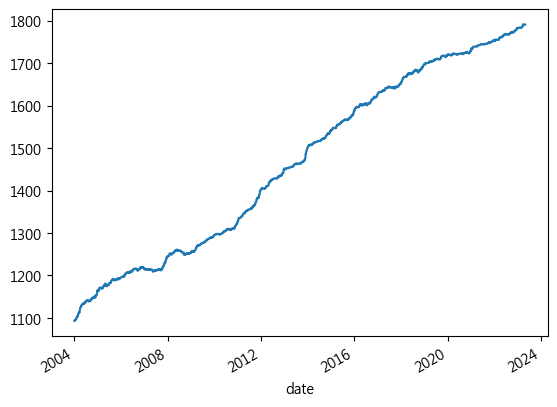

In [7]:
df_factor_all.groupby('date')['ticker'].count().plot()

In [8]:
df_price = pd.read_feather('data/cmoney_price.feather')
df_price = ut.cmoney_data_clean_up(df_price)
df_price['日期'] = pd.to_datetime(df_price['日期'])


df_price_sub = df_price[['日期','股票代號','收盤價','成交量','成交金額(千)']].copy()
df_price_sub.columns = ['date','ticker','close','volume','amount(k)']

df_price_sub.sort_values(["ticker", "date"], inplace=True)
df_price_sub.reset_index(drop=True, inplace=True)
df_price_sub['20_d_mean_amount_k'] = df_price_sub.groupby('ticker', as_index=False)['amount(k)'].rolling(20).mean()['amount(k)']


df_price_div = df_price[['日期','股票代號','收盤價']].copy()
df_price_div.columns = ['date','ticker','unadj_price']
df_price_div['date'] = pd.to_datetime(df_price_div['date'])
# sort by date for shift
df_price_div.sort_values(['ticker','date'],inplace=True)
# shift to get last day price
df_price_div['yesterday_price'] = df_price_div.groupby('ticker')['unadj_price'].shift(1)
df_price_div['unadj_price'] = df_price_div['unadj_price'].astype(float)
df_price_div['yesterday_price'] = df_price_div['yesterday_price'].astype(float)

In [9]:
# load df_factor from data/model/model_folder_name/df_factor_all.feather
df_factor_all = pd.read_feather(f'./data/model/{model_folder_name}/df_factor_all_testing.feather')
# df_factor_all = pd.read_feather(f'data/df_factor_all.feather')

# create a dataframe for model mapping
df_model_mapping = pd.DataFrame()
df_model_mapping['rebalance_date'] = setting['rebalance_date_lst'][setting['start_index'] + 0:]
df_model_mapping['model_path'] = model_list
# convert rebalance_date to datetime
df_model_mapping['rebalance_date'] = pd.to_datetime(df_model_mapping['rebalance_date'])

# merge the df_model_mapping and df_factor_all
df_factor_all = pd.merge(df_factor_all, df_model_mapping, left_on='date', right_on='rebalance_date', how='left')
df_factor_all = df_factor_all.sort_values(['date','ticker']).reset_index(drop=True)
df_factor_all['model_path'].fillna(method='ffill', inplace=True)
df_factor_all['rebalance_date'].fillna(method='ffill', inplace=True)
df_factor_all.dropna(subset=['model_path'], inplace=True)
factor_columns = setting['factor_columns']
df_factor_all.dropna(subset=factor_columns, inplace=True)

df_factor_all = df_factor_all.reset_index(drop=True)

df_rebalance_date = pd.DataFrame()
df_rebalance_date['date'] = setting['rebalance_date_lst']
# set date to datetime format
df_rebalance_date['date'] = pd.to_datetime(df_rebalance_date['date'])
df_backtest_return = pd.merge(df_rebalance_date, df_adjusted_price, how='left', left_on='date', right_on='年月日')[['date','股票代號','收盤價(元)']].copy()

df_backtest_return.rename(columns={'股票代號':'ticker'}, inplace=True)
df_backtest_return.rename(columns={'收盤價(元)':'price'}, inplace=True)
df_backtest_return['price'] = df_backtest_return['price'].astype(float)
df_backtest_return['price_shift'] = df_backtest_return.groupby('ticker', group_keys=False)['price'].shift(-1)
df_backtest_return['rebalance_period_return'] = df_backtest_return['price_shift'] / df_backtest_return['price'] - 1

df_factor_all = df_factor_all.merge(df_backtest_return[['date','ticker','rebalance_period_return']], on=['date','ticker'], how='left')

df_factor_all_select = df_factor_all.copy()

df_factor_all.to_feather(f'./data/model/{model_folder_name}/df_factor_all_select.feather')

In [10]:
df_factor_all = df_factor_all[df_factor_all['date'] == df_factor_all['rebalance_date']].copy()

In [11]:
# # load df_factor from data/model/model_folder_name/df_factor_all.feather
# df_factor_all = pd.read_feather(f'./data/model/{model_folder_name}/df_factor_all_testing.feather')
# # df_factor_all = pd.read_feather(f'data/df_factor_all.feather')

# df_factor_all = df_factor_all.reset_index(drop=True)
# df_factor_all = deepcopy(df_factor_all)

# date_list = np.sort(pd.unique(df_factor_all['date']))
# rebalance_date_lst = ut.get_monthly_end_rebalance_date(date_list, pd.to_datetime('2004-02-25'))
# data_freezed_date_lst = ut.get_data_freezed_date(date_list, rebalance_date_lst, days_shift=0)

# df_rebalance_date = pd.DataFrame()
# df_rebalance_date['rebalance_date'] = rebalance_date_lst
# df_rebalance_date['data_freezed_date'] = data_freezed_date_lst


# df_backtest_return = pd.merge(df_rebalance_date, df_adjusted_price, how='left', left_on='rebalance_date', right_on='年月日').copy()

# df_backtest_return.rename(columns={'股票代號':'ticker'}, inplace=True)
# df_backtest_return.rename(columns={'收盤價(元)':'price'}, inplace=True)
# df_backtest_return['price'] = df_backtest_return['price'].astype(float)
# df_backtest_return['price_shift'] = df_backtest_return.groupby('ticker', group_keys=False)['price'].shift(-1)
# df_backtest_return['rebalance_period_return'] = df_backtest_return['price_shift'] / df_backtest_return['price'] - 1
# df_backtest_return = df_backtest_return[['data_freezed_date','ticker','rebalance_date','rebalance_period_return']].copy()

# df_factor_all = pd.merge(df_factor_all, df_backtest_return, how='left', left_on=['date','ticker'], right_on=['data_freezed_date','ticker']).dropna(subset=['data_freezed_date']).copy()

In [12]:
df_factor_all.sort_values(['date','ticker'], inplace=True)
df_factor_all.reset_index(drop=True, inplace=True)

In [13]:
df_factor_all['market_cap_billion'] = df_factor_all['market_cap'] / 1000000
df_factor_all['market_cap_rank'] = df_factor_all.groupby('date')['market_cap'].rank(ascending=False)

In [14]:
# set market cap larger than 10 billion
df_plot_market_cap = df_factor_all[df_factor_all['market_cap_billion'] > 10].sort_values('market_cap_rank').groupby('date').tail(1)[['date','market_cap_rank']].reset_index(drop=True)
# plot market cap rank, with date as x-axis, with grid
# df_plot_market_cap.plot(x='date', y='market_cap_rank', figsize=(20, 8), title='market cap rank', grid=True)

# Set Parmas

In [15]:
CAP_TOP = 50
CAP_BOT = 250
AMOUNT_FLOOR = 50
N = 30
YIELD = 3
TURNOVER = 20
cell_heights = [.3, .2]

df_sample_pool = df_factor_all[(df_factor_all["market_cap_rank"] > 50) & (df_factor_all["market_cap_rank"] <= 200)].copy()
# df_sample_pool = df_factor_all.copy()

In [16]:

# factors = setting['factor_columns']
# num_cut = 5

# factor_name = []
# median_diff = []
# mean_diff = []


# for factor in factors:
#     if factor != 'last_dividend_yield':
#         df_sample_pool[f'{factor}_rank'] = df_sample_pool.groupby('date')[f'{factor}'].rank(ascending=False)
#         df_sample_pool[f'{factor}_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)[f'{factor}_rank'].apply(lambda x: pd.qcut(x, num_cut, labels=False, duplicates="drop"))
#         df_temp_des = df_sample_pool.groupby([f'{factor}_rank_qcut'])['rebalance_period_return'].describe()
        
#         factor_name.append(factor)
#         median_diff.append(round(df_temp_des["50%"][0] - df_temp_des["50%"][num_cut - 1], 4))
#         mean_diff.append(round(df_temp_des["mean"][0] - df_temp_des["mean"][num_cut - 1], 4))

# df_factor_diff = pd.DataFrame({'factor': factor_name, 'median_diff': median_diff, 'mean_diff': mean_diff})

# df_factor_diff['abs_total_diff'] = df_factor_diff['median_diff'].abs() + df_factor_diff['mean_diff'].abs() 
# df_factor_diff.sort_values('abs_total_diff', ascending=False).head(10)

In [17]:
num_cut = 5
df_sample_pool['roe_rank'] = df_sample_pool.groupby('date')['roe'].rank(ascending=False)
df_sample_pool['roe_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['roe_rank'].apply(lambda x: pd.qcut(x, num_cut, labels=False, duplicates="drop"))

df_sample_pool['60_d_return_rank'] = df_sample_pool.groupby('date')['60_d_return'].rank(ascending=False)
df_sample_pool['60_d_return_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['60_d_return_rank'].apply(lambda x: pd.qcut(x, num_cut, labels=False, duplicates="drop"))

df_sample_pool['40_d_return_rank'] = df_sample_pool.groupby('date')['40_d_return'].rank(ascending=False)
df_sample_pool['tobins_q_rank'] = df_sample_pool.groupby('date')['tobins_q'].rank(ascending=False)
df_sample_pool['tobins_q_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['tobins_q_rank'].apply(lambda x: pd.qcut(x, num_cut, labels=False, duplicates="drop"))

df_sample_pool['roe_4q_sum_rank'] = df_sample_pool.groupby('date')['roe_4q_sum'].rank(ascending=False)
df_sample_pool['roe_4q_sum_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['roe_4q_sum_rank'].apply(lambda x: pd.qcut(x, num_cut, labels=False, duplicates="drop"))

df_sample_pool['ni_yoy_rank'] = df_sample_pool.groupby('date')['ni_yoy'].rank(ascending=False)
df_sample_pool['ni_yoy_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['ni_yoy_rank'].apply(lambda x: pd.qcut(x, num_cut, labels=False, duplicates="drop"))

df_sample_pool['ocf / asset_rank'] = df_sample_pool.groupby('date')['ocf / asset'].rank(ascending=False)
df_sample_pool['ocf / asset_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['ocf / asset_rank'].apply(lambda x: pd.qcut(x, num_cut, labels=False, duplicates="drop"))

df_sample_pool['rank_sum_1'] = df_sample_pool['roe_rank']
df_sample_pool['rank_sum_1_rank'] = df_sample_pool.groupby('date')['rank_sum_1'].rank(ascending=True)
df_sample_pool['rank_sum_1_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['rank_sum_1_rank'].apply(lambda x: pd.qcut(x, num_cut, labels=False, duplicates="drop"))

df_sample_pool['rank_sum_2'] = df_sample_pool['roe_rank'] + df_sample_pool['60_d_return_rank']
df_sample_pool['rank_sum_2_rank'] = df_sample_pool.groupby('date')['rank_sum_2'].rank(ascending=True)
df_sample_pool['rank_sum_2_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['rank_sum_2_rank'].apply(lambda x: pd.qcut(x, num_cut, labels=False, duplicates="drop"))

df_sample_pool['rank_sum_3'] = df_sample_pool['roe_rank'] + df_sample_pool['60_d_return_rank'] + df_sample_pool['ni_yoy_rank']
df_sample_pool['rank_sum_3_rank'] = df_sample_pool.groupby('date')['rank_sum_3'].rank(ascending=True)
df_sample_pool['rank_sum_3_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['rank_sum_3_rank'].apply(lambda x: pd.qcut(x, num_cut, labels=False, duplicates="drop"))

# df_sample_pool['rank_sum_4'] = df_sample_pool['roe_rank'] * df_sample_pool['60_d_return_rank'] * df_sample_pool['ni_yoy_rank'] * df_sample_pool['roe_4q_sum_rank'] 
# df_sample_pool['rank_sum_4_rank'] = df_sample_pool.groupby('date')['rank_sum_4'].rank(ascending=True)
# df_sample_pool['rank_sum_4_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['rank_sum_4_rank'].apply(lambda x: pd.qcut(x, num_cut, labels=False, duplicates="drop"))

# df_sample_pool['rank_sum_5'] = df_sample_pool['roe_rank']**2 + df_sample_pool['60_d_return_rank']**2 + df_sample_pool['ni_yoy_rank']**2 + df_sample_pool['roe_4q_sum_rank']**2
# df_sample_pool['rank_sum_5_rank'] = df_sample_pool.groupby('date')['rank_sum_5'].rank(ascending=True)
# df_sample_pool['rank_sum_5_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['rank_sum_5_rank'].apply(lambda x: pd.qcut(x, num_cut, labels=False, duplicates="drop"))

# df_sample_pool['rank_sum_6'] = df_sample_pool['roe_rank_qcut']**2 + df_sample_pool['60_d_return_rank_qcut']**2 + df_sample_pool['ni_yoy_rank_qcut']**2 + df_sample_pool['roe_4q_sum_rank_qcut']**2
# df_sample_pool['rank_sum_6_rank'] = df_sample_pool.groupby('date')['rank_sum_6'].rank(ascending=True)
# df_sample_pool['rank_sum_6_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['rank_sum_6_rank'].apply(lambda x: pd.qcut(x, num_cut, labels=False, duplicates="drop"))

In [18]:



df_temp = pd.merge(df_sample_pool, df_price_sub, how="left", on=["date", "ticker"])
df_temp = df_temp.dropna()

df_temp['20_d_mean_amount_floor'] = df_temp['20_d_mean_amount_k'] > AMOUNT_FLOOR * 1000

df_liq_pool = df_temp[df_temp['20_d_mean_amount_floor'] == True].copy()

In [19]:
def top_n(df, n=5, columns=['last_dividend_yield', 'predict_rank'], ascending=[False, True]):
    return df.sort_values(by=columns, ascending=ascending).head(n)


def calculate_cagr(df):
    # Add 1 to all the quarterly returns
    df_plus_one = df + 1
    # Calculate the cumulative product of the returns
    cum_product = df_plus_one.cumprod()
    # Get the total number of years
    num_years = len(df) / 4
    # Calculate CAGR
    cagr = (cum_product.iloc[-1])**(1/num_years) - 1
    return cagr


def calculate_cagr(df):
    # Add 1 to all the quarterly returns
    df_plus_one = df + 1
    # Calculate the cumulative product of the returns
    cum_product = df_plus_one.cumprod()
    # Get the total number of years
    num_years = len(df) / 4
    # Calculate CAGR
    cagr = (cum_product.iloc[-1])**(1/num_years) - 1
    return cagr

In [20]:
df_select_pool_top_50 = df_liq_pool.groupby('date').apply(top_n, n=30, columns=['rank_sum_3_rank'], ascending=[True])

df_select_pool_top_50.reset_index(drop=True, inplace=True)
# df_select_pool_top_50_return = df_select_pool_top_50.groupby('date')['y'].mean()
df_select_pool_top_50_return = df_select_pool_top_50.groupby('date')['rebalance_period_return'].mean()
print("不做選股Buffer | 只排序 1.rank_sum_3_rank")
print(f"SR: {((df_select_pool_top_50_return + 1).prod() ** (4/len(df_select_pool_top_50_return)) -1 ) / (df_select_pool_top_50_return.std() * np.sqrt(4)):.2f}")
# Assuming your DataFrame is named df_returns
cagr = calculate_cagr(df_select_pool_top_50_return)
print(f"CAGR: {cagr:.2%}")
print(f"Std: {(df_select_pool_top_50_return.std() * np.sqrt(4)):.2%}")

不做選股Buffer | 只排序 1.rank_sum_3_rank
SR: 0.51
CAGR: 14.63%
Std: 28.54%


# Pre-filtering the dividend yield

In [21]:
# df_market_cap_melt.to_feather('./data/df_market_cap_melt.feather')
# df_market_cap_melt = pd.read_feather('./data/df_market_cap_melt.feather')


df_filter_dividends_yield = df_liq_pool[df_liq_pool['dividend_1Y_sum_yield'] > (YIELD / 100)].copy()

# df_price_liquidity_flag.to_feather('./data/df_price_liquidity_flag.feather')
df_select_filter_dividends_yield = df_filter_dividends_yield.reset_index(drop=True)
df_select_filter_dividends_yield_top_N = df_select_filter_dividends_yield.groupby('date').apply(top_n, n=30, columns=['rank_sum_3_rank'], ascending=[True])

df_select_filter_dividends_yield_top_N.reset_index(drop=True, inplace=True)
# df_select_filter_dividends_yield_top_N_return = df_select_filter_dividends_yield_top_N.groupby('date')['y'].mean()
df_select_filter_dividends_yield_top_N_return = df_select_filter_dividends_yield_top_N.groupby('date')['rebalance_period_return'].mean()
print("不做選股Buffer | 只排序 1.rank_sum_5_rank")
print(f"SR: {((df_select_filter_dividends_yield_top_N_return + 1).prod() ** (4/len(df_select_filter_dividends_yield_top_N_return)) -1 ) / (df_select_filter_dividends_yield_top_N_return.std() * np.sqrt(4)):.2f}")
# Assuming your DataFrame is named df_returns
cagr = calculate_cagr(df_select_filter_dividends_yield_top_N_return)
print(f"CAGR: {cagr:.2%}")
print(f"Std: {(df_select_filter_dividends_yield_top_N_return.std() * np.sqrt(4)):.2%}")
df_select_filter_dividends_yield_top_N.to_feather(f'./data/model/{model_folder_name}/df_cap_{CAP_TOP}_{CAP_BOT}_amount_{AMOUNT_FLOOR}M_yield_{YIELD}_top_{N}.feather')


不做選股Buffer | 只排序 1.rank_sum_5_rank
SR: 0.49
CAGR: 13.51%
Std: 27.34%


In [22]:
df_select_filter_dividends_yield_benchmark = df_sample_pool.dropna().groupby('date').apply(top_n, n=30, columns=['market_cap_rank'], ascending=[True])

df_select_filter_dividends_yield_benchmark.reset_index(drop=True, inplace=True)
# df_select_filter_dividends_yield_benchmark_return = df_select_filter_dividends_yield_benchmark.groupby('date')['y'].mean()
df_select_filter_dividends_yield_benchmark_return = df_select_filter_dividends_yield_benchmark.groupby('date')['rebalance_period_return'].mean()
print("Pool 不做選股Buffer | 只排序 1.市值")
print(f"SR: {((df_select_filter_dividends_yield_benchmark_return + 1).prod() ** (4/len(df_select_filter_dividends_yield_benchmark_return)) -1 ) / (df_select_filter_dividends_yield_benchmark_return.std() * np.sqrt(4)):.2f}")
# Assuming your DataFrame is named df_returns
cagr = calculate_cagr(df_select_filter_dividends_yield_benchmark_return)
print(f"CAGR: {cagr:.2%}")
print(f"Std: {(df_select_filter_dividends_yield_benchmark_return.std() * np.sqrt(4)):.2%}")


Pool 不做選股Buffer | 只排序 1.市值
SR: 0.33
CAGR: 8.92%
Std: 27.11%


In [23]:
df_select_filter_dividends_yield_benchmark.to_feather(f'./data/model/{model_folder_name}/df_select_filter_dividends_yield_benchmark.feather')

# Restrict Turnover

In [24]:

reb_lst = df_factor_all['rebalance_date'].unique()
apply_restrict_index = 1
base_portfolio_number = 30
restrict_turnover = TURNOVER / 100
sort_column = 'rank_sum_3_rank'
remain_number =  int(np.ceil(base_portfolio_number * (1 - restrict_turnover)))

# round up the restrict_portfolio_number
restrict_portfolio_number =  (base_portfolio_number * 2 - remain_number)

df_select_pool = df_filter_dividends_yield.reset_index(drop=True)
# get the base portfolio by base_portfolio_number 
df_select_pool_base = df_select_pool.groupby('date').apply(top_n, n = base_portfolio_number, columns=[sort_column], ascending=[True]).reset_index(drop=True)
# get the restrict portfolio by restrict_portfolio_number
df_select_pool_restrict = df_select_pool
df_select_pool_restrict.reset_index(drop=True, inplace=True)

apply_restrict_date = np.sort(reb_lst)[apply_restrict_index]
# string format
apply_restrict_date = pd.to_datetime(apply_restrict_date).strftime('%Y-%m-%d')
print(f'自 {apply_restrict_date} 開始使用 restrict 建構投組')

df_restrict_result = pd.DataFrame([])
# concat the data that date is smaller than apply_restrict_date to df_restrict_result
df_restrict_result = pd.concat([df_restrict_result, df_select_pool_base[df_select_pool_base['date'] < apply_restrict_date]], axis=0)
# print the max date in df_restrict_result
print(f"df_restrict_result['date'].max(): {df_restrict_result['date'].max()}")


for i in range(apply_restrict_index, len(reb_lst)):
# i = 1

    # get the slice data by reb_lst[i] in df_select_pool_restrict
    df_select_pool_restrict_temp = df_select_pool_restrict[df_select_pool_restrict['rebalance_date'] == reb_lst[i]].reset_index(drop=True)

    # get the slice data by reb_lst[i-1] in df_restrict_result, [i-1] is because we need to get the last portfolio
    df_restrict_result_temp = df_restrict_result[df_restrict_result['rebalance_date'] == reb_lst[i - 1]].reset_index(drop=True)

    # prepare the dataframe for finding the joint ticker
    df_new_temp = df_select_pool_restrict_temp[['date','ticker',sort_column, 'dividend_1Y_sum_yield']].copy()
    df_new_temp['restrict'] = 1
    df_new_temp.sort_values([sort_column,'dividend_1Y_sum_yield'], ascending=True, inplace=True)
    df_new_temp.reset_index(drop=True, inplace=True)

    last_portfolio_ticker_list = df_restrict_result_temp['ticker'].unique()

    df_priority_temp = df_select_pool_restrict_temp[df_select_pool_restrict_temp['ticker'].isin(last_portfolio_ticker_list)].copy()
    df_priority_temp.sort_values([sort_column,'dividend_1Y_sum_yield'], ascending=True, inplace=True)
    df_priority_temp.reset_index(drop=True, inplace=True)
    df_priority = df_priority_temp.head(remain_number)


    df_added = df_new_temp[df_new_temp['ticker'].isin(df_priority['ticker'].unique()) == False].head(base_portfolio_number - len(df_priority)).reset_index(drop=True)
    df_triviality = df_select_pool_restrict_temp[df_select_pool_restrict_temp['ticker'].isin(df_added['ticker'].unique())].reset_index(drop=True)

    df_restrict_result_temp = pd.concat([df_priority, df_triviality], axis=0)

    # concat the df_restrict_result_temp to df_restrict_result
    df_restrict_result = pd.concat([df_restrict_result, df_restrict_result_temp], axis=0)

df_restrict_result.reset_index(drop=True, inplace=True)
# df_restrict_result_return = df_restrict_result.groupby('date')['y'].mean()
df_restrict_result_return = df_restrict_result.groupby('date')['rebalance_period_return'].mean()

print(f'./data/model/{model_folder_name}/df_restrict_result_{apply_restrict_index}_{base_portfolio_number}_{restrict_portfolio_number}')
df_restrict_result.to_feather(f'./data/model/{model_folder_name}/df_turnover_{TURNOVER}_cap_{CAP_TOP}_{CAP_BOT}_amount_{AMOUNT_FLOOR}M_yield_{YIELD}_top_{N}.feather')
print(f"SR: {((df_restrict_result_return + 1).prod()**(4/len(df_restrict_result_return)) -1 ) / (df_restrict_result_return.std() * np.sqrt(4)):.2f}")
# Assuming your DataFrame is named df_returns
cagr = calculate_cagr(df_restrict_result_return)
print(f"CAGR: {cagr:.2%}")
print(f"Std: {(df_restrict_result_return.std() * np.sqrt(4)):.2%}")


自 2005-05-25 開始使用 restrict 建構投組
df_restrict_result['date'].max(): 2005-02-25 00:00:00
./data/model/20230724_091431/df_restrict_result_1_30_36
SR: 0.49
CAGR: 13.51%
Std: 27.31%


## Index Components

In [25]:
df_company_info = pd.read_feather('data/df_company_info.feather')

In [26]:
# df_company_info_sub = df_company_info[['股票代號','股票名稱','產業名稱','上市上櫃']].copy()
# df_company_info_sub = df_company_info_sub.drop_duplicates().reset_index(drop=True)
# df_components = pd.merge(df_restrict_result[['date','ticker']], df_company_info_sub, how = 'left', left_on = 'ticker', right_on = '股票代號')
# df_components_date = df_components.groupby('date')['產業名稱'].value_counts().reset_index().groupby('date').head(5)
# # df_components.groupby('date')['產業名稱'].value_counts().reset_index().groupby('date').head(5).to_excel('data/df_components.xlsx', index=False)

# df_company_info_sub = df_company_info[['股票代號','股票名稱','產業名稱','上市上櫃']].copy()
# df_company_info_sub = df_company_info_sub.drop_duplicates().reset_index(drop=True)
# df_components = pd.merge(df_select_filter_dividends_yield_top_50[['date','ticker']], df_company_info_sub, how = 'left', left_on = 'ticker', right_on = '股票代號')
# df_components_date = df_components.groupby('date')['產業名稱'].value_counts().reset_index().groupby('date').head(5)
# # df_components.groupby('date')['產業名稱'].value_counts().reset_index().groupby('date').head(5).to_excel('data/df_components_t50.xlsx', index=False)

# df_components = pd.merge(df_select_filter_dividends_yield_top_50[['date','ticker']], df_company_info_sub, how = 'left', left_on = 'ticker', right_on = '股票代號')
# df_components = pd.merge(df_select_filter_dividends_yield_top_50[['date','ticker']], df_company_info_sub, how = 'left', left_on = 'ticker', right_on = '股票代號')
# df_components.drop_duplicates(subset=['date','ticker'], inplace=True, keep = 'first')
# df_listed_market = df_components.groupby(['date','上市上櫃'])['ticker'].count().reset_index()

In [27]:
# plot the line chart for df_listed_market by date and 上市上櫃
# df_listed_market.pivot(index='date', columns='上市上櫃', values='ticker').plot.line(figsize=(20,10), title='上市上櫃股票數量', fontsize=20)
# plt.grid()

# Calculate Daily Portfolio Return

In [28]:
df_adjusted_price_temp = df_adjusted_price.copy()
df_adjusted_price_temp.columns = ['date','ticker','price']

In [29]:
def get_daily_portfolio(df_rebalance):

    df_portfolio_value_all = pd.DataFrame([])
    portfolio_quarterly_return = []
    portfolio_value = 1000000000

    for i in range(len(reb_lst) - 1):

        df_select_portfolio = df_rebalance.copy()

        df_select_portfolio_copy = df_select_portfolio[df_select_portfolio['date'] == reb_lst[i]].copy()
        df_select_portfolio_copy.sort_values('ticker', inplace=True)
        ticker_list = df_select_portfolio_copy['ticker'].unique()

        if len(df_portfolio_value_all) == 0:
            df_select_portfolio_copy['portfolio_value'] = portfolio_value / len(ticker_list)
        else:
            df_select_portfolio_copy['portfolio_value'] = df_portfolio_value_all['portfolio_value'].iloc[-1] / len(ticker_list)

        df_select_portfolio_copy.reset_index(drop=True, inplace=True)
        # give the weight to each stock by market cap
        # df_select_portfolio_copy['portfolio_value'] = df_select_portfolio_copy['portfolio_value'] * df_select_portfolio_copy['market_cap'] / df_select_portfolio_copy['market_cap'].sum()

        df_adjusted_price_temp_period = df_adjusted_price_temp[(df_adjusted_price_temp['ticker'].isin(ticker_list)) & (df_adjusted_price_temp['date'] >= reb_lst[i]) & (df_adjusted_price_temp['date'] <= reb_lst[i + 1])].copy()
        # check if there is price missing

        if df_adjusted_price_temp_period.groupby('ticker')['date'].count().max() != df_adjusted_price_temp_period.groupby('ticker')['date'].count().min():
            print('fuck')
            
        df_adjusted_price_temp_period.sort_values(['ticker','date'], inplace=True)
        df_adjusted_price_temp_period.reset_index(drop=True, inplace=True)
        df_adjusted_price_temp_period['price_shift'] = df_adjusted_price_temp_period.groupby('ticker')['price'].shift(1)
        df_adjusted_price_temp_period['rt'] = df_adjusted_price_temp_period['price'] / df_adjusted_price_temp_period['price_shift']
        df_adjusted_price_temp_period['rt'].fillna(1, inplace=True)
        # pivot the rt
        df_rt_pivot = df_adjusted_price_temp_period.pivot(index='date', columns='ticker', values='rt').copy()

        df_portfolio_value = df_rt_pivot.cumprod().mul(df_select_portfolio_copy['portfolio_value'].values).sum(axis=1).reset_index().rename(columns={0:'portfolio_value'})
        # print return by sub the last value by the first value
        portfolio_quarterly_return.append(df_portfolio_value['portfolio_value'].iloc[-1] / df_portfolio_value['portfolio_value'].iloc[0] - 1)

        df_portfolio_value_all = pd.concat([df_portfolio_value_all, df_portfolio_value], axis=0)

    df_portfolio_value_all = df_portfolio_value_all.copy()
    df_portfolio_value_all['date'] = pd.to_datetime(df_portfolio_value_all['date'])
    df_portfolio_value_all['portfolio_value'] = df_portfolio_value_all['portfolio_value'].round(0)
    df_portfolio_value_all = df_portfolio_value_all.drop_duplicates()

    return df_portfolio_value_all

In [30]:
# df_portfolio_value_all = get_daily_portfolio(df_restrict_result)
df_portfolio_value_all = get_daily_portfolio(df_restrict_result)

In [31]:
df_portfolio_top_50 = get_daily_portfolio(df_select_filter_dividends_yield_top_N)

# Compare with benchmarks(Daily)

In [32]:
# create f'./figs/{model_folder_name}' folder if not exist

import os
# create f'./figs/{model_folder_name}' folder if not exist
if not os.path.exists(f'./figs/{model_folder_name}'):
    os.makedirs(f'./figs/{model_folder_name}')

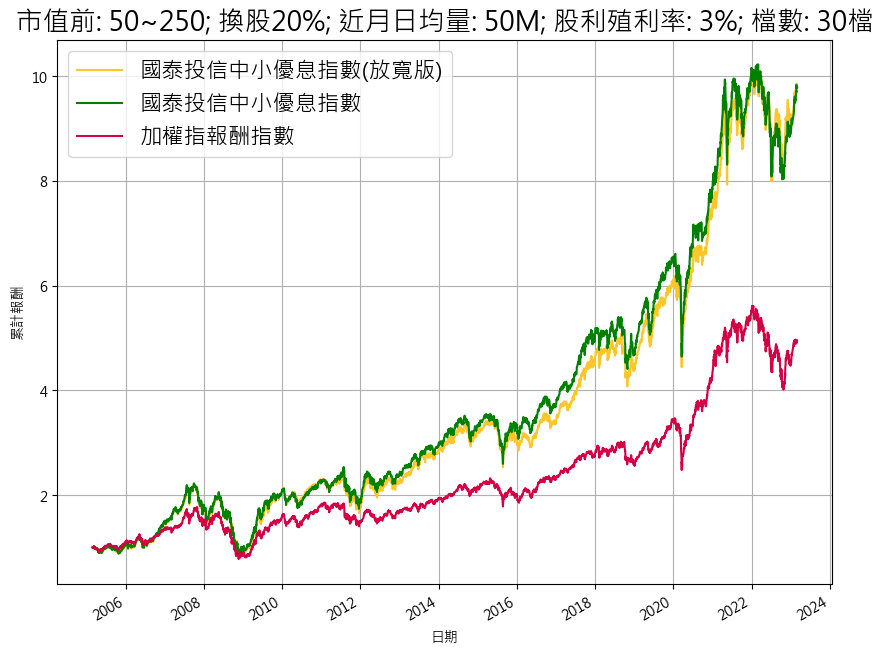

In [33]:
df_compare_portfolio = df_portfolio_value_all.copy()
df_compare_portfolio.columns = ['date','portfolio_value']
df_compare_portfolio_2 = df_portfolio_top_50.copy()
df_compare_portfolio_2.columns = ['date','portfolio_value_2']

df_benchmarks_all = pd.read_excel('./data/benchmarks.xlsx')
df_benchmarks_all.columns = ['日期', 'TWA02', '台灣精選高息報酬指數', '台灣ESG低碳高息40報酬指數', '微波高息精選20報酬指數', '特選台灣產業龍頭存股等權重報酬指數', '存股雙十等權重報酬指數']
benchmark_list = df_benchmarks_all.columns.to_list()
benchmark_list.remove('日期')
benchmark_list.remove('台灣精選高息報酬指數')
benchmark_list.remove('特選台灣產業龍頭存股等權重報酬指數')

index_name = benchmark_list[0]
df_benchmarks_temp = df_benchmarks_all[['日期',f'{index_name}']].copy()
df_benchmarks_temp.columns = ['date',f'{index_name}']
df_benchmarks_temp.dropna(inplace=True)
# change the date format to datetime
df_benchmarks_temp['date'] = pd.to_datetime(df_benchmarks_temp['date'], format='%Y/%m/%d')
df_benchmarks_temp.sort_values('date', inplace=True)
df_benchmarks_temp = df_benchmarks_temp.merge(df_compare_portfolio, on='date', how='left').dropna().copy()
df_benchmarks = df_benchmarks_temp.merge(df_compare_portfolio_2, on='date', how='left').dropna().copy()
df_benchmarks.reset_index(drop=True, inplace=True)
df_benchmarks.drop_duplicates(inplace=True)

# df_benchmarks = df_benchmarks[df_benchmarks['date']> '2018-08-01']
# scale the benchmark and portfolio value to 1
df_benchmarks[f'{index_name}_scale'] = df_benchmarks[f'{index_name}'] / df_benchmarks[f'{index_name}'].iloc[0]
df_benchmarks['portfolio_value_scale'] = df_benchmarks['portfolio_value'] / df_benchmarks['portfolio_value'].iloc[0]
df_benchmarks['portfolio_value_scale_2'] = df_benchmarks['portfolio_value_2'] / df_benchmarks['portfolio_value_2'].iloc[0]

df_benchmarks.set_index('date', inplace=True)
df_benchmarks[['portfolio_value_scale_2', 'portfolio_value_scale', f'{index_name}_scale']].plot(figsize=(10,8), color=['#ffc629','green','#d30046'])

matplotlib.rcParams['font.size'] = 16

plt.grid(True)
plt.title(f'市值前: {CAP_TOP}~{CAP_BOT}; 換股{TURNOVER}%; 近月日均量: {AMOUNT_FLOOR}M; 股利殖利率: {YIELD}%; 檔數: {N}檔')
plt.xlabel('日期')
# Set legend names
plt.legend(['國泰投信中小優息指數(放寬版)', '國泰投信中小優息指數', '加權指報酬指數'])
# plt.legend(['國泰投信中小優息指數', index_name])
plt.ylabel('累計報酬')
plt.grid(True)
plt.savefig(f'./figs/{model_folder_name}/中小_{index_name}_turnover_{TURNOVER}_cap_{CAP_TOP}_{CAP_BOT}_amount_{AMOUNT_FLOOR}M_yield_{YIELD}_top_{N}.png', bbox_inches='tight')

In [34]:
df_benchmarks['portfolio_value_rt'] = df_benchmarks['portfolio_value_scale'].pct_change()
df_benchmarks['portfolio_value_rt_2'] = df_benchmarks['portfolio_value_scale_2'].pct_change()
df_benchmarks[f'{index_name}_rt'] = df_benchmarks[f'{index_name}_scale'].pct_change()

In [35]:
# calculate the beta of portfolio and benchmark
beta = df_benchmarks[['portfolio_value_rt', f'{index_name}_rt']].cov().iloc[0,1] / df_benchmarks[f'{index_name}_rt'].var()
print(f'beta: {beta:.2f}')
beta_2 = df_benchmarks[['portfolio_value_rt_2', f'{index_name}_rt']].cov().iloc[0,1] / df_benchmarks[f'{index_name}_rt'].var()
print(f'beta_2: {beta_2:.2f}')

beta: 0.96
beta_2: 0.96


In [36]:
# calculate the alpha of portfolio and benchmark
alpha = df_benchmarks[['portfolio_value_rt', f'{index_name}_rt']].mean().iloc[0] - beta * df_benchmarks[f'{index_name}_rt'].mean()
# annualize the alpha
ann_alpha = (1+alpha)**240 - 1

print(f'alpha: {ann_alpha:.2%}')
alpha_2 = df_benchmarks[['portfolio_value_rt_2', f'{index_name}_rt']].mean().iloc[0] - beta_2 * df_benchmarks[f'{index_name}_rt'].mean()
ann_alpha_2 = (1+alpha_2)**240 - 1
print(f'alpha_2: {ann_alpha_2:.2%}')

alpha: 4.57%
alpha_2: 4.60%


In [37]:
df_benchmarks['year'] = df_benchmarks.index.year
df_benchmarks['month'] = df_benchmarks.index.month
df_benchmarks['quarter'] = df_benchmarks.index.quarter

In [38]:
last_values = df_benchmarks.groupby(['year','month']).tail(1)[[f'{index_name}','portfolio_value_scale','portfolio_value_scale_2']].values
first_values  = df_benchmarks.groupby(['year','month']).head(1)[[f'{index_name}','portfolio_value_scale','portfolio_value_scale_2']].values
df_monthly_return = pd.DataFrame(last_values / first_values)
df_monthly_return.columns = [f'{index_name}','portfolio_value_scale','portfolio_value_scale_2']
# drop the last row
df_monthly_return = df_monthly_return[:-1]
df_monthly_return['win_rate'] = np.where(df_monthly_return['portfolio_value_scale'] > df_monthly_return[f'{index_name}'], 1, 0)
df_monthly_return['win_rate_2'] = np.where(df_monthly_return['portfolio_value_scale_2'] > df_monthly_return[f'{index_name}'], 1, 0)

In [39]:
df_monthly_return['portfolio_rt'] = df_monthly_return['portfolio_value_scale'].pct_change()
df_monthly_return['portfolio_rt_2'] = df_monthly_return['portfolio_value_scale_2'].pct_change()
df_monthly_return[f'{index_name}_rt'] = df_monthly_return[f'{index_name}'].pct_change()

In [40]:
# # plot the monthly return distribution
# # Set global font to 'Microsoft JhengHei'
# # Set global font to 'Microsoft JhengHei'
# matplotlib.rcParams['font.family'] = 'Arial'
# matplotlib.rcParams['font.family'] = 'Microsoft JhengHei'
# matplotlib.rcParams['axes.unicode_minus'] = False


# # set the bin of hist by range
# bins = np.arange(-0.2, 0.2, 0.02)

# df_monthly_return[f'portfolio_rt_2'].hist(bins=bins, figsize=(8,8), color='#ffc629ff', alpha=0.5)
# df_monthly_return['portfolio_rt'].hist(bins=bins, figsize=(8,8), color='#0faf00ff', alpha=0.5)

# # plt.legend([f'{index_name}', '國泰投信中小高股息指數(放寬版)'])

# # set the legend under the plot
# plt.legend(['國泰投信中小高股息指數(放寬版)', '國泰投信中小高股息指數'], loc='upper center', bbox_to_anchor=(0.5, 1.1), fancybox=True, shadow=True, ncol=2)

# # format the yticks with % without other module
# plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))


# plt.show()

In [41]:
# # plot the monthly return distribution
# # Set global font to 'Microsoft JhengHei'
# # Set global font to 'Microsoft JhengHei'
# matplotlib.rcParams['font.family'] = 'Arial'
# matplotlib.rcParams['font.family'] = 'Microsoft JhengHei'
# matplotlib.rcParams['axes.unicode_minus'] = False

# # set the bin of hist by range
# bins = np.arange(-0.2, 0.2, 0.02)

# df_monthly_return[f'{index_name}_rt'].hist(bins=bins, figsize=(8,8), color='#ff0c5d', alpha=0.5)
# df_monthly_return['portfolio_rt_2'].hist(bins=bins, figsize=(8,8), color='#ffc629ff', alpha=0.5)

# # plt.legend([f'{index_name}', '國泰投信中小高股息指數(放寬版)'])

# # set the legend under the plot
# plt.legend([f'{index_name}', '國泰投信中小高股息指數(放寬版)'], loc='upper center', bbox_to_anchor=(0.5, 1.1), fancybox=True, shadow=True, ncol=2)

# # format the yticks with % without other module
# plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))


# plt.show()

In [42]:
last_values = df_benchmarks.groupby(['year','month']).tail(1)[[f'{index_name}','portfolio_value_scale','portfolio_value_scale_2']].values
first_values  = df_benchmarks.groupby(['year','month']).head(1)[[f'{index_name}','portfolio_value_scale','portfolio_value_scale_2']].values
df_quarterly_return = pd.DataFrame(last_values / first_values)
df_quarterly_return.columns = [f'{index_name}','portfolio_value_scale','portfolio_value_scale_2']
# drop the last row
# df_quarterly_return = df_quarterly_return[:-1]
df_quarterly_return['win_rate'] = np.where(df_quarterly_return['portfolio_value_scale'] > df_quarterly_return[f'{index_name}'], 1, 0)
df_quarterly_return['win_rate_2'] = np.where(df_quarterly_return['portfolio_value_scale_2'] > df_quarterly_return[f'{index_name}'], 1, 0)

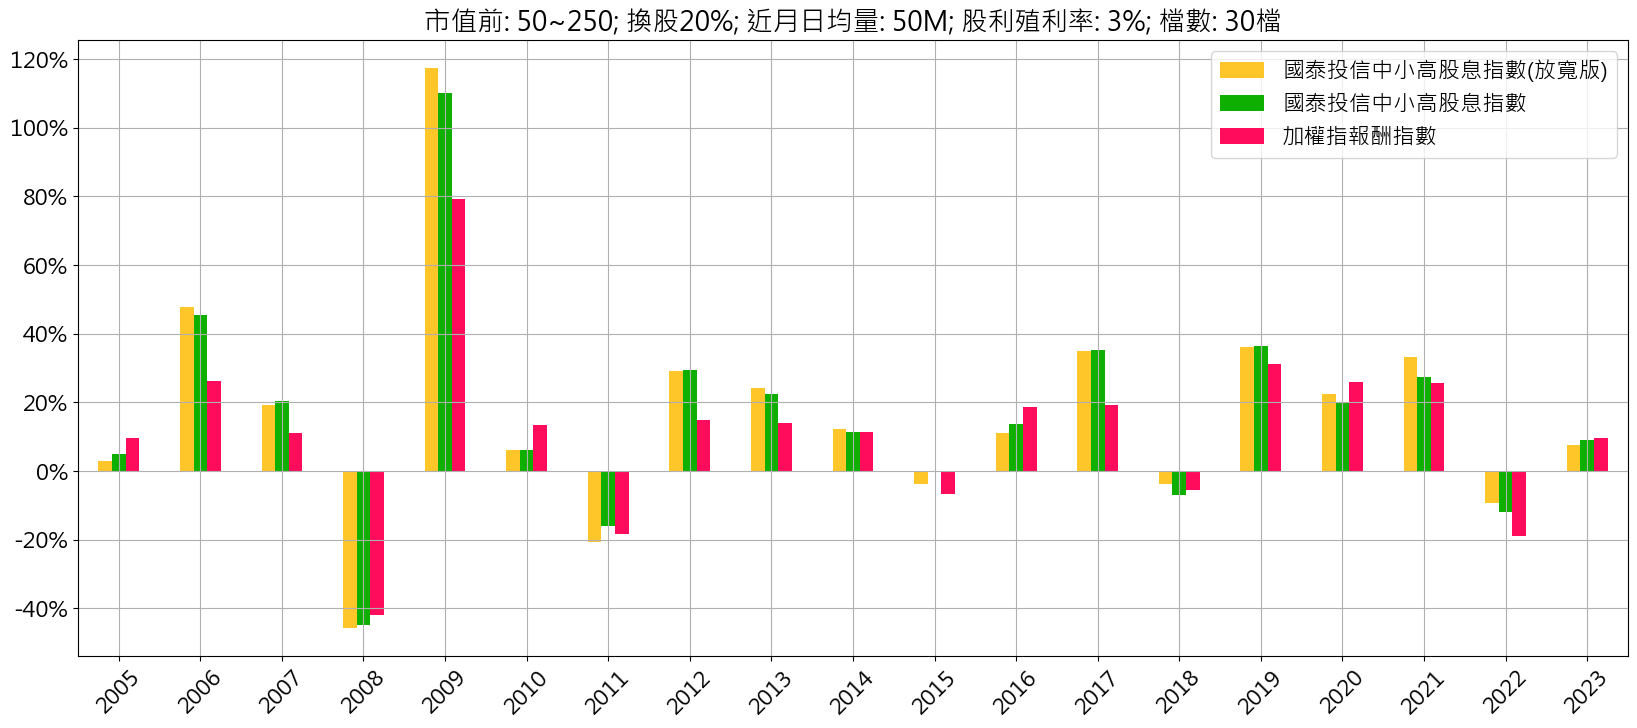

In [43]:
last_values = df_benchmarks.groupby(['year']).tail(1)[[f'{index_name}','portfolio_value_scale','portfolio_value_scale_2']].values
first_values  = df_benchmarks.groupby(['year']).head(1)[[f'{index_name}','portfolio_value_scale','portfolio_value_scale_2']].values
df_yearly_return = pd.DataFrame(last_values / first_values)
df_yearly_return.columns = [f'{index_name}','portfolio_value_scale','portfolio_value_scale_2']
# drop the last row
# df_yearly_return = df_yearly_return[:-1]
df_yearly_return['win_rate'] = np.where(df_yearly_return['portfolio_value_scale'] > df_yearly_return[f'{index_name}'], 1, 0)
df_yearly_return['win_rate_2'] = np.where(df_yearly_return['portfolio_value_scale_2'] > df_yearly_return[f'{index_name}'], 1, 0)
# create a list from 2005 to 2023 for year column for df_yearly_return
year_list = list(range(2005,2024))
df_yearly_return['year'] = year_list

df_yearly_return[['portfolio_value_scale','portfolio_value_scale_2',f'{index_name}']] = df_yearly_return[['portfolio_value_scale','portfolio_value_scale_2',f'{index_name}']] - 1

# plot the return of portfolio and benchmark with bar chart
df_yearly_return[['portfolio_value_scale_2','portfolio_value_scale',f'{index_name}']].plot.bar(figsize=(20,8), color=['#ffc629ff','#0faf00ff','#ff0c5d'])


import matplotlib.ticker as mtick
# set font with Arial
matplotlib.rcParams['font.family'] = 'Arial'

# Set global font to 'Microsoft JhengHei'
matplotlib.rcParams['font.family'] = ['Microsoft JhengHei']

# set the x axis with column year
plt.xticks(df_yearly_return.index, df_yearly_return['year'])

plt.rcParams['axes.unicode_minus'] = False
# rotate the x axis 45 degree
plt.xticks(rotation=45)

# format the yticks with % without other module
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend(['國泰投信中小高股息指數(放寬版)', '國泰投信中小高股息指數', '加權指報酬指數'])
plt.grid()
plt.title(f'市值前: {CAP_TOP}~{CAP_BOT}; 換股{TURNOVER}%; 近月日均量: {AMOUNT_FLOOR}M; 股利殖利率: {YIELD}%; 檔數: {N}檔')
plt.savefig(f'./figs/{model_folder_name}/中小_{index_name}_turnover_{TURNOVER}_cap_{CAP_TOP}_{CAP_BOT}_amount_{AMOUNT_FLOOR}M_yield_{YIELD}_top_{N}_年度報酬.png', bbox_inches='tight')



In [44]:
df_benchmarks_temp.reset_index(inplace=True, drop=True)
df_benchmarks_temp.set_index('date', inplace=True)

In [45]:
# calc the sharpe ratio of portfolio with daily return with function
def calc_sharpe_ratio(series):
    return ((series.pct_change().mean() * 252) / (series.pct_change().std() * np.sqrt(252)))

series_sr = calc_sharpe_ratio(df_benchmarks)[:3]

In [46]:
# calc the CAGR with the last value and the first value of portfolio value
def calculate_cagr(series):
    # get the last value of portfolio value
    last_value = series.iloc[-1]
    # get the first value of portfolio value
    first_value = series.iloc[0]
    # get the total number of years
    num_years = len(series) / 252
    # calc the CAGR
    cagr = (last_value / first_value)**(1/num_years) - 1
    return cagr

series_cagr = calculate_cagr(df_benchmarks)[:3]

# Merge main 8

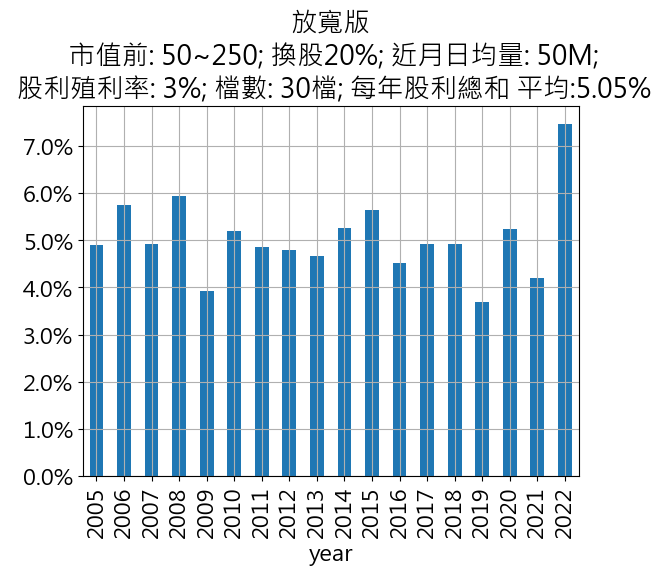

In [47]:
select_ticker = df_select_filter_dividends_yield_top_N['ticker'].unique()

df_cash_dividends = pd.read_feather('data/tej_cash_dividends.feather')
df_cash_dividends = ut.tej_data_clean_up(df_cash_dividends)
df_cash_dividends = df_cash_dividends[['股票代號','除息日','息值(元)']].copy()
df_cash_dividends.columns = ['ticker','date','dividend']
df_cash_dividends = df_cash_dividends[df_cash_dividends['ticker'].isin(select_ticker)].copy()
df_cash_dividends.drop_duplicates(inplace=True)
df_cash_dividends['dividend'] = df_cash_dividends['dividend'].astype(float)
df_cash_dividends = df_cash_dividends.groupby(['ticker','date']).sum().reset_index()

df_factor_all_price = pd.merge(df_factor_all_select,df_price_div,on=['date','ticker'],how='left')
df_factor_all_price_dividend = pd.merge(df_factor_all_price,df_cash_dividends,on=['date','ticker'],how='left')
df_factor_all_price_dividend['unadj_yield'] = df_factor_all_price_dividend['dividend'] / df_factor_all_price_dividend['yesterday_price']

# calculate the sum of dividend yield of each stock in each period 
df_period_yield = df_factor_all_price_dividend.groupby(['ticker','rebalance_date'], as_index=False, group_keys=False)['unadj_yield'].sum()

# merge the sum of dividend yield to df_dividend_select for calculate the portfolio dividend yield
df_dividend_select_yield = pd.merge(df_select_filter_dividends_yield_top_N,df_period_yield,on=['ticker','rebalance_date'],how='left')

df_quarterly_div = df_dividend_select_yield.groupby('rebalance_date')['unadj_yield'].mean().reset_index()
df_quarterly_div['year'] = df_quarterly_div['rebalance_date'].dt.year

mean_div = round(df_quarterly_div.groupby('year')['unadj_yield'].sum().mean() * 100, 2)
df_quarterly_div.groupby('year')['unadj_yield'].sum().plot(kind='bar')

df_quarterly_div.groupby('year')['unadj_yield'].sum().reset_index().to_excel(f'./figs/{model_folder_name}/中小_{index_name}_turnover_{TURNOVER}_cap_{CAP_TOP}_{CAP_BOT}_amount_{AMOUNT_FLOOR}M_yield_{YIELD}_top_{N}_Yield_放寬版.xlsx')

# format the yticks with % without other module
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid()

plt.title(f'放寬版\n 市值前: {CAP_TOP}~{CAP_BOT}; 換股{TURNOVER}%; 近月日均量: {AMOUNT_FLOOR}M;\n 股利殖利率: {YIELD}%; 檔數: {N}檔; 每年股利總和 平均:{mean_div}%')
plt.savefig(f'./figs/{model_folder_name}/中小_{index_name}_turnover_{TURNOVER}_cap_{CAP_TOP}_{CAP_BOT}_amount_{AMOUNT_FLOOR}M_yield_{YIELD}_top_{N}_股利_放寬版.png', bbox_inches='tight')


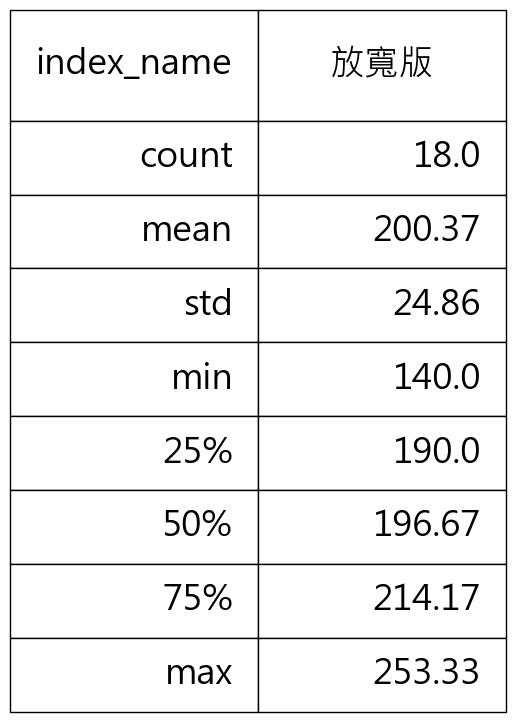

In [48]:
# create the weight column for each ticker, weight = 1 / total num of ticker in the rebalance date
df_dividend_select_yield['weight'] = 1 / df_dividend_select_yield.groupby('rebalance_date')['ticker'].transform('count')

df_weight = pd.pivot(df_dividend_select_yield, index='rebalance_date', columns='ticker', values='weight').copy()
df_weight.fillna(0,inplace=True)

# calculate the turnover by calculate the abs change of weight and sum up
df_weight_change = df_weight.diff().abs() / 2 * 100
df_quarterly_turnover = df_weight_change.sum(axis=1).reset_index()
df_quarterly_turnover.columns = ['rebalance_date','turnover']

df_quarterly_turnover['year'] = df_quarterly_turnover['rebalance_date'].dt.year
df_quarterly_turnover['quarter'] = df_quarterly_turnover['rebalance_date'].dt.quarter
df_yearly_turnover = (df_quarterly_turnover.groupby('year')['turnover'].mean() * 4).reset_index()
# df_yearly_turnover = df_quarterly_turnover.groupby('quarter')['turnover'].mean().reset_index()
df_turnover = df_yearly_turnover['turnover'].describe().reset_index()
df_turnover.columns = ['index_name', '放寬版']

fig, ax = create_table(df_turnover, cell_heights)
plt.savefig(f'./figs/{model_folder_name}/中小_{index_name}_turnover_{TURNOVER}_cap_{CAP_TOP}_{CAP_BOT}_amount_{AMOUNT_FLOOR}M_yield_{YIELD}_top_{N}_Turnover_放寬版.png', bbox_inches='tight')


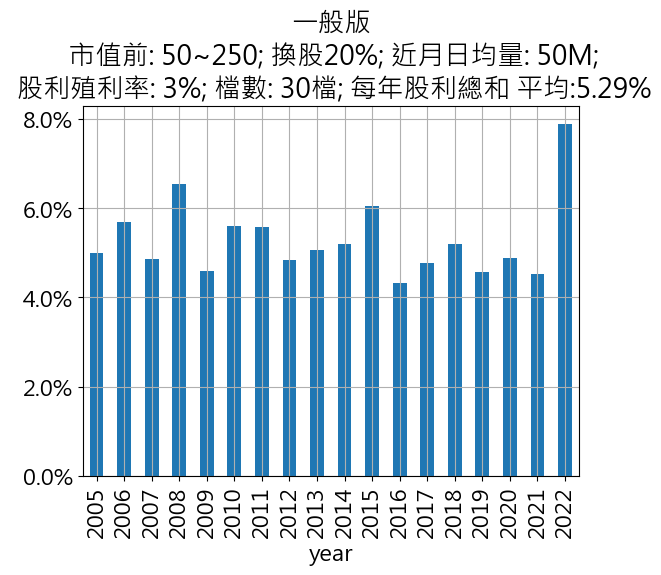

In [49]:
select_ticker = df_restrict_result['ticker'].unique()

df_cash_dividends = pd.read_feather('data/tej_cash_dividends.feather')
df_cash_dividends = ut.tej_data_clean_up(df_cash_dividends)
df_cash_dividends = df_cash_dividends[['股票代號','除息日','息值(元)']].copy()
df_cash_dividends.columns = ['ticker','date','dividend']
df_cash_dividends = df_cash_dividends[df_cash_dividends['ticker'].isin(select_ticker)].copy()
df_cash_dividends.drop_duplicates(inplace=True)
df_cash_dividends['dividend'] = df_cash_dividends['dividend'].astype(float)
df_cash_dividends = df_cash_dividends.groupby(['ticker','date']).sum().reset_index()

df_factor_all_price = pd.merge(df_factor_all_select,df_price_div,on=['date','ticker'],how='left')
df_factor_all_price_dividend = pd.merge(df_factor_all_price,df_cash_dividends,on=['date','ticker'],how='left')
df_factor_all_price_dividend['unadj_yield'] = df_factor_all_price_dividend['dividend'] / df_factor_all_price_dividend['yesterday_price']

# calculate the sum of dividend yield of each stock in each period 
df_period_yield = df_factor_all_price_dividend.groupby(['ticker','rebalance_date'], as_index=False, group_keys=False)['unadj_yield'].sum()

# merge the sum of dividend yield to df_dividend_select for calculate the portfolio dividend yield
df_dividend_select_yield = pd.merge(df_restrict_result,df_period_yield,on=['ticker','rebalance_date'],how='left')

df_quaterly_div = df_dividend_select_yield.groupby('rebalance_date')['unadj_yield'].mean().reset_index()
df_quaterly_div['year'] = df_quaterly_div['rebalance_date'].dt.year

mean_div = round(df_quaterly_div.groupby('year')['unadj_yield'].sum().mean() * 100, 2)
df_quaterly_div.groupby('year')['unadj_yield'].sum().plot(kind='bar')

df_quarterly_div.groupby('year')['unadj_yield'].sum().reset_index().to_excel(f'./figs/{model_folder_name}/中小_{index_name}_turnover_{TURNOVER}_cap_{CAP_TOP}_{CAP_BOT}_amount_{AMOUNT_FLOOR}M_yield_{YIELD}_top_{N}_Yield_一般版.xlsx')

# format the yticks with % without other module
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid()

plt.title(f'一般版\n 市值前: {CAP_TOP}~{CAP_BOT}; 換股{TURNOVER}%; 近月日均量: {AMOUNT_FLOOR}M;\n 股利殖利率: {YIELD}%; 檔數: {N}檔; 每年股利總和 平均:{mean_div}%')
plt.savefig(f'./figs/{model_folder_name}/中小_{index_name}_turnover_{TURNOVER}_cap_{CAP_TOP}_{CAP_BOT}_amount_{AMOUNT_FLOOR}M_yield_{YIELD}_top_{N}_股利_一般版.png', bbox_inches='tight')


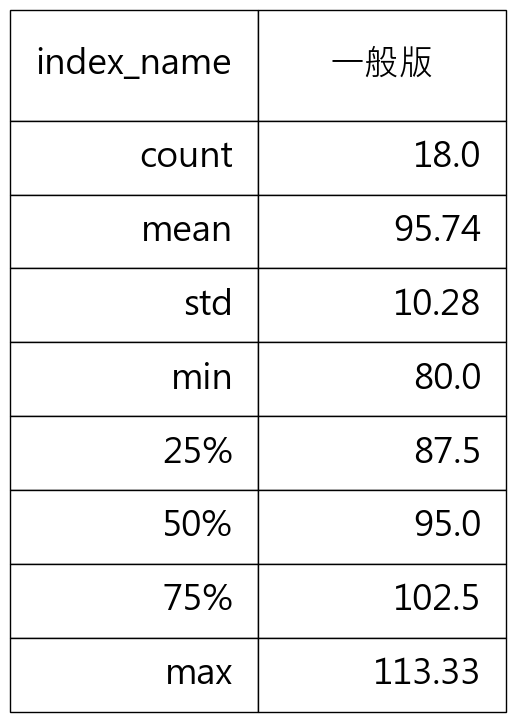

In [50]:
# create the weight column for each ticker, weight = 1 / total num of ticker in the rebalance date
df_dividend_select_yield['weight'] = 1 / df_dividend_select_yield.groupby('rebalance_date')['ticker'].transform('count')

df_weight = pd.pivot(df_dividend_select_yield, index='rebalance_date', columns='ticker', values='weight').copy()
df_weight.fillna(0,inplace=True)

# calculate the turnover by calculate the abs change of weight and sum up
df_weight_change = df_weight.diff().abs() / 2 * 100
df_quarterly_turnover = df_weight_change.sum(axis=1).reset_index()
df_quarterly_turnover.columns = ['rebalance_date','turnover']

df_quarterly_turnover['year'] = df_quarterly_turnover['rebalance_date'].dt.year
df_quarterly_turnover['quarter'] = df_quarterly_turnover['rebalance_date'].dt.quarter
df_yearly_turnover = (df_quarterly_turnover.groupby('year')['turnover'].mean() * 4).reset_index()
# df_yearly_turnover = df_quarterly_turnover.groupby('quarter')['turnover'].mean().reset_index()
df_turnover = df_yearly_turnover['turnover'].describe().reset_index()
df_turnover.columns = ['index_name', '一般版']

fig, ax = create_table(df_turnover, cell_heights)
plt.savefig(f'./figs/{model_folder_name}/中小_{index_name}_turnover_{TURNOVER}_cap_{CAP_TOP}_{CAP_BOT}_amount_{AMOUNT_FLOOR}M_yield_{YIELD}_top_{N}_Turnover_一般版.png', bbox_inches='tight')


# Summary

In [51]:
df_summary = pd.DataFrame()
df_summary['CAGR'] = series_cagr
df_summary['Sharpe Ratio'] = series_sr
df_summary['CAGR'] = df_summary['CAGR'].astype(float).apply(lambda x: "{:.2%}".format(x))
df_summary['Sharpe Ratio'] = df_summary['Sharpe Ratio'].astype(float).apply(lambda x: "{:.2f}".format(x))
df_summary = df_summary.transpose().copy()
df_summary.reset_index(inplace=True)


In [52]:
df_summary.columns = ['數值', '加權報酬指數', '中小優息-一般版', '中小優息-放寬版']

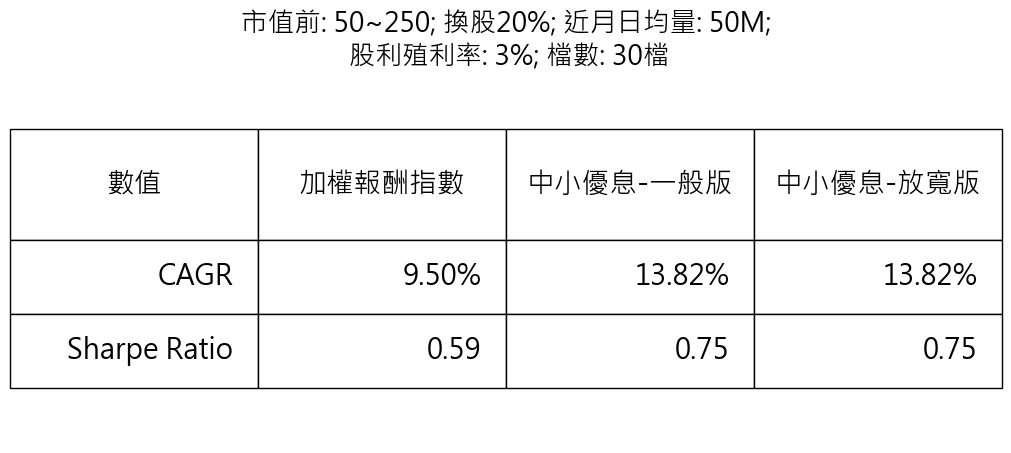

In [53]:
fig, ax = create_table(df_summary, cell_heights)
plt.title(f'市值前: {CAP_TOP}~{CAP_BOT}; 換股{TURNOVER}%; 近月日均量: {AMOUNT_FLOOR}M;\n 股利殖利率: {YIELD}%; 檔數: {N}檔')
plt.savefig(f'./figs/{model_folder_name}/中小_{index_name}_turnover_{TURNOVER}_cap_{CAP_TOP}_{CAP_BOT}_amount_{AMOUNT_FLOOR}M_yield_{YIELD}_top_{N}_Summary.png', bbox_inches='tight')


In [54]:
df_daily_nav = df_benchmarks[['TWA02_scale','portfolio_value_scale','portfolio_value_scale_2']]
df_daily_nav.columns = ['加權報酬指數', '中小優息-一般版', '中小優息-放寬版']
df_daily_nav.to_excel(f'./figs/{model_folder_name}/中小_{index_name}_turnover_{TURNOVER}_cap_{CAP_TOP}_{CAP_BOT}_amount_{AMOUNT_FLOOR}M_yield_{YIELD}_top_{N}_Daily_value.xlsx')